In [1]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os
import json
from PIL import Image, ImageDraw
import shutil

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.0/617.0 kB 6.6 MB/s eta 0:00:00


In [3]:
os.makedirs('datasets', exist_ok=True)
%cd datasets

/content/datasets


In [4]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

download_file(
    'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1f_lMiqo5_2BO9-03SPh5O3meG6HasM9p',
    'urban_dataset.zip'
)


In [5]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('urban_dataset.zip')
%cd ..

Extracted all
/content


In [6]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [7]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [8]:
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()


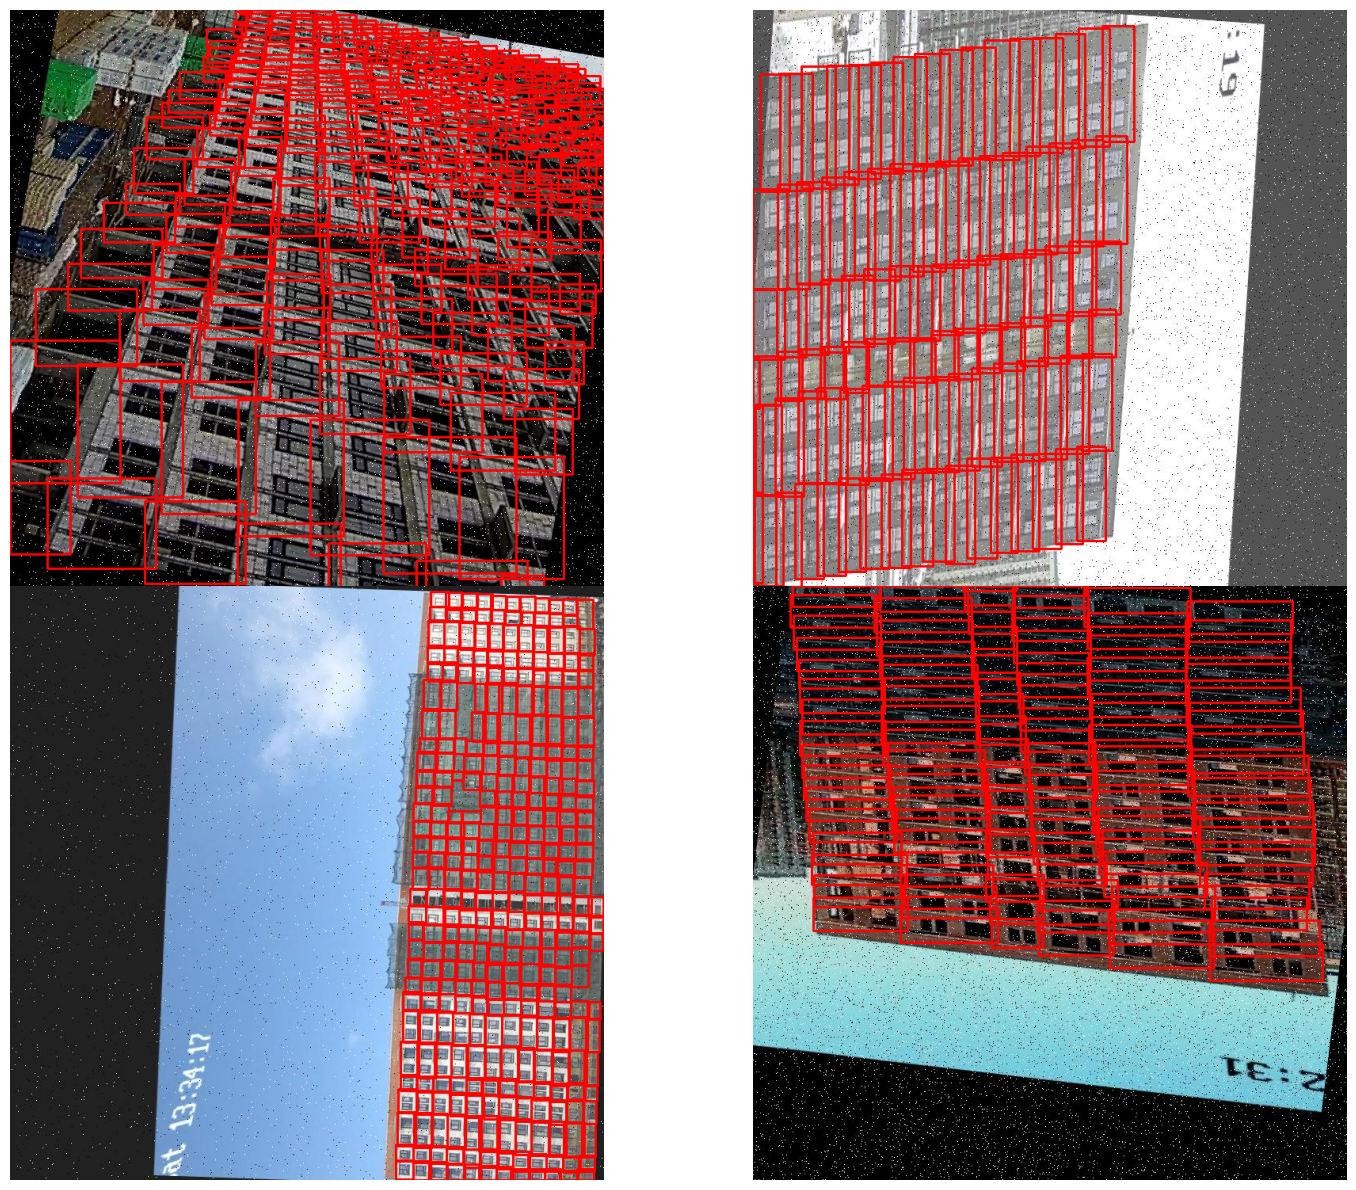

In [9]:
# Visualize a few training images.
plot(
    image_paths='datasets/train/images/',
    label_paths='datasets/train/labels/',
    num_samples=4,
)

In [10]:
# c Этого момента начинается обучение модели ( пока не работает)
%%writefile conf.yaml
path: './datasets/'
train: 'train/images'
val: 'valid/images'
test: 'test/images'

names:
  0: 'window'
  1: 'empty'
  2: 'filled'

Writing conf.yaml


In [ ]:
!yolo task=detect mode=train model=yolov8s.pt imgsz=700 data=conf.yaml epochs=14 batch=16 name=yolov8s_custom lr0=1e-05

100% 21.5M/21.5M [00:00<00:00, 84.0MB/s]
Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=conf.yaml, epochs=14, patience=50, batch=16, imgsz=700, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, form

In [ ]:
!yolo task=detect mode=val model=runs/detect/yolov8s_custom/weights/best.pt name=yolov8s_eval data=conf.yaml

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients
val: Scanning /content/datasets/valid/labels.cache... 25 images, 0 backgrounds, 0 corrupt: 100% 25/25 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:04<00:00,  2.32s/it]
                   all         25       4750      0.839       0.75      0.809      0.572
                window         25       1055      0.867      0.785      0.858      0.596
                 empty         25       1981      0.856      0.688      0.747      0.544
                filled         25       1714      0.795      0.777      0.822      0.577
Speed: 0.3ms preprocess, 25.1ms inference, 0.0ms loss, 10.4ms postprocess per image
Results saved to runs/detect/yolov8s_eval
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8s_custom/weights/best.pt \
source=datasets/test/images \
imgsz=700 \
name=yolov8s_custom_finish \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients

WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
image 1/13 /content/datasets/test/images/0000001913building_jpg.rf.ab1ae78b9e57f5de444a870ded31d581.jpg: 704x704 161 windows, 112 emptys, 18.8ms
image 2/13 /content/datasets/test/images/0000005494building_jpg.rf.523f0efb26cd273191ee061fc861a3f2.jpg: 704x704 7 windows, 1 empty, 18.8ms
image 3/13 /content/datasets/test/images/0000006327building_jpg.rf.e1726b289334a4acc8f66b9791288d68.jpg: 704x704 39 windows, 170 emptys, 1 filled, 18.7ms
image 4/13 /content/datasets/test/images/0000006838building_jpg.rf.dbc56ca4d8be30de0898dc0fb1c66f7d.jpg: 704x704 7 windows, 230 emptys, 63 filleds, 18.8ms
image 5/13 /content/datasets/test/images/000

In [ ]:
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(10, 10))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
      image = plt.imread(image_name)
      plt.subplot(2, 2, i+1)
      plt.imshow(image)
      plt.axis('off')
      if i == num_samples-1:
        break
    plt.tight_layout()
    plt.show()

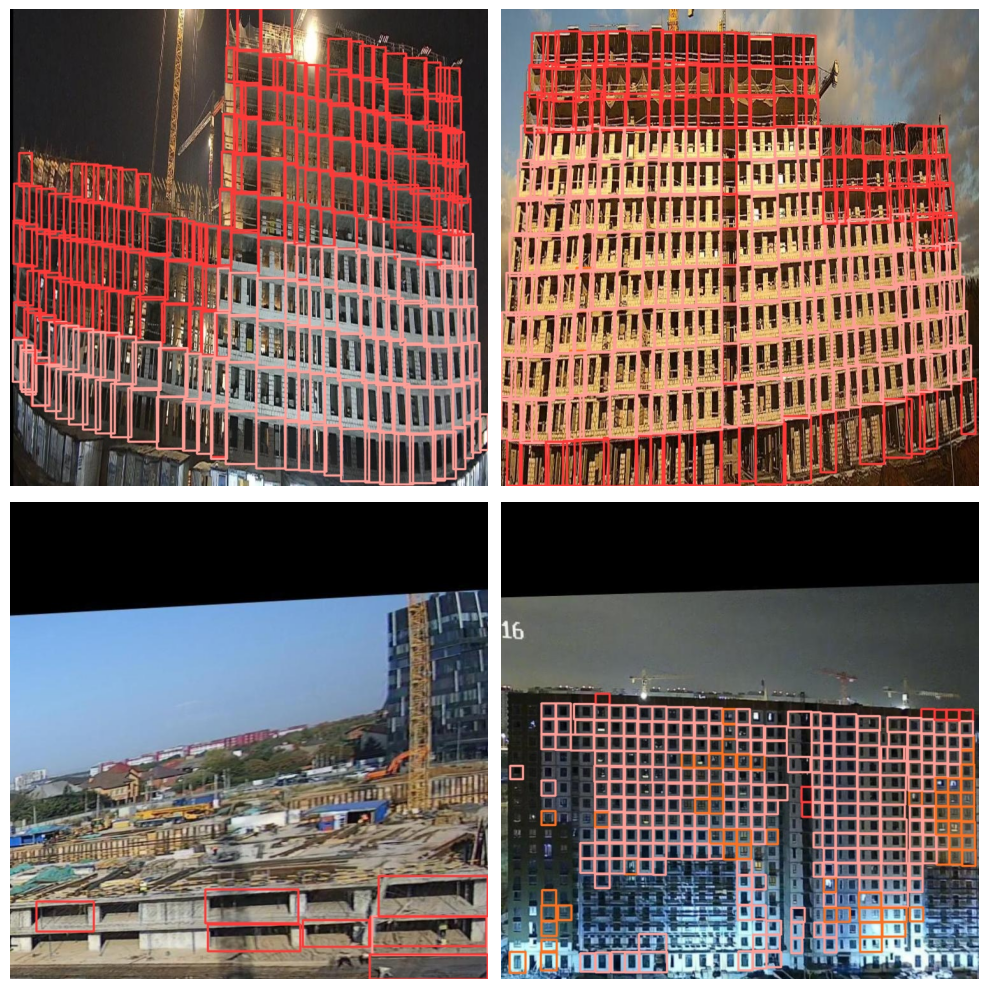

In [ ]:
visualize('runs/detect/yolov8s_custom_finish/')


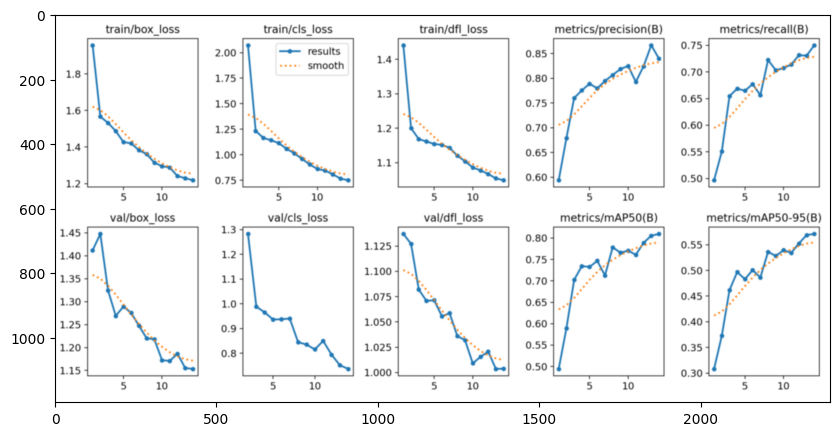

In [ ]:
img=Image.open("/content/runs/detect/yolov8s_custom/results.png")
plt.figure(figsize=(10, 10))
plt.imshow(img, interpolation='bicubic')
plt.show()